In [1]:
!which python3

/Users/gabyagrocostea/.pyenv/versions/3.11.2/bin/python3


In [ ]:
# these need to be installed
!pip install textblob
!pip install wordcloud
!pip install vaderSentiment

In [2]:
# import statements
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from ast import literal_eval # to read list as list in dataframe
# text preprocessing
import re
from nltk.corpus import stopwords
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# Visualize word counts
from collections import Counter
from wordcloud import WordCloud

### NLP Sentiment Analysis
* Data Analysis on top reviews based on glassdoor.com scrapping
* TextBlob sentiment analysis - polarity & subjectivity exploration
* Vader sentiment analysis - compound scores exploration

In [3]:
sns.set_style('whitegrid')

In [4]:
data_dir = "/Users/gabyagrocostea/dev/glassdoor/data/"
files = os.listdir(data_dir)

In [5]:
# do some data pre-processing to read list as a list and not string
# note: dropped the few rows with missing data
data = pd.DataFrame()
for f in files:
    if f.endswith(".csv"):
        print(f"Reading {f}")
        temp = pd.read_csv(os.path.join(data_dir, f), index_col=0)
        temp = temp[~temp.reviews.isnull()]
        temp.reviews = temp.reviews.apply(literal_eval)
        data = pd.concat([data, temp], axis=0)

Reading df_4.csv
Reading df_3.csv
Reading df_2.csv
Reading df_1.csv


In [6]:
# let s look at data
data[['company','job_title','stars','reviews']].head(10)

,company,job_title,stars,reviews
0,Bloomberg,Senior NLP Research Engineer - Artificial Inte...,4.1,"[""a good place to ""retire"" since benefits are ..."
1,"JPMorgan Chase Bank, N.A.",Machine Learning Scientist - Natural Language ...,3.8,"[""great benefits and the company really tries ..."
2,Kensho,Senior Applied Scientist - Document Intelligence,3.9,"[""Interesting problems, great people, flexibil..."
3,"JPMorgan Chase Bank, N.A.","Artificial Intelligence Research Scientist, Re...",3.8,"[""great benefits and the company really tries ..."
5,Siemens Healthineers,Senior Scientist - NLP,4.1,"[""Good initiatives Work life balance"" (in 32 r..."
0,Bloomberg,Applied Machine Learning Scientist - Data Tech...,4.1,"[""Work life balance is good not great among fi..."
1,Eisai,"Associate Director, Medical Digital Strategy a...",3.8,"[""Salaries and benefits are ok."" (in 1 reviews..."
2,Bloomberg,Applied Statistician - Data Technologies,4.1,"[""a good place to ""retire"" since benefits are ..."
3,Bloomberg,Business Information Modeler - Enterprise Plat...,4.1,"[""Good benefits and opportunities to move arou..."
4,Bloomberg,Applied LLM Researcher - Code - CTO Office,4.1,"[""a good place to ""retire"" since benefits are ..."


In [7]:
# how many distinct companies do we have?
data.company.nunique()

47

In [8]:
# 80 rows of data
data.shape

(80, 8)

In [9]:
# let's look at company openings and stars
company_stats = data.groupby('company').agg({'job_id':'count','stars':'mean'})
company_stats.rename(columns={"job_id": "openings", "stars":"avg_stars"}, inplace=True)
company_stats.reset_index(inplace=True)

In [10]:
# companies ordered by highest number of stars on avg
company_stats.sort_values(by='avg_stars', ascending=False)[:10]

,company,openings,avg_stars
25,Notion,1,4.8
30,Philo,2,4.7
32,Prospect 33,1,4.6
31,Power Home Remodeling,1,4.6
9,Etsy,3,4.5
41,TECHSTRA SOLUTIONS,1,4.4
20,Mitchell Martin,1,4.3
40,Synchrony Financial,1,4.3
12,INFUSEmedia,1,4.3
22,NYU Langone Health,1,4.3


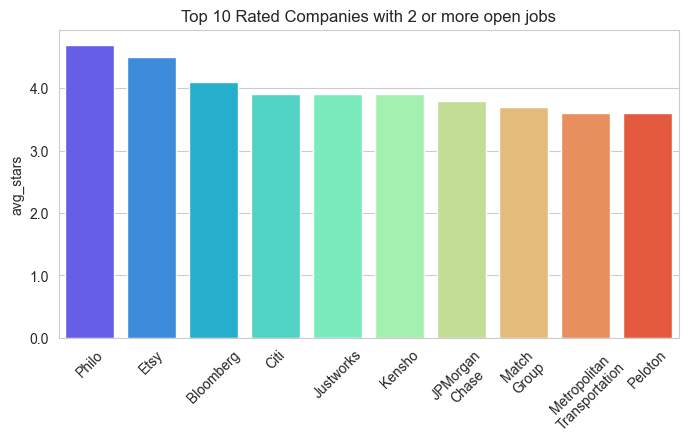

In [11]:
# create bar chart for companies with 2 or more openings by average star rating
fig, ax = plt.subplots(figsize=(8,4))
g = sns.barplot(data = company_stats[company_stats.openings>=2].sort_values(by='avg_stars',ascending=False)[:10],
            x = 'company', y = 'avg_stars', ax = ax, palette='rainbow')
labels = [i.get_text() for i in g.get_xticklabels()]
labels = ["\n".join(i.split(" ")[0:2]) for i in labels]
_ = ax.set_xticklabels(labels=labels, rotation = 45)
_ = ax.set_title('Top 10 Rated Companies with 2 or more open jobs')
_ = ax.set_xlabel("")
_ = ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(np.round(x,2), ',')))

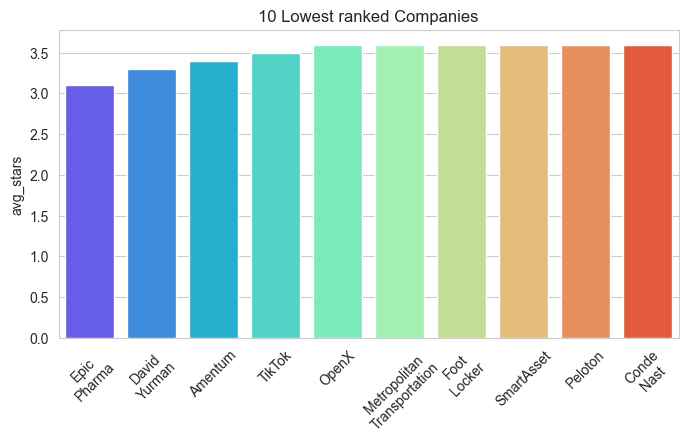

In [12]:
# lowest ranked companies based on average star ratings (bottom 10)
fig, ax = plt.subplots(figsize=(8,4))
g = sns.barplot(data = company_stats.sort_values(by='avg_stars', ascending=True)[:10],
            x = 'company', y = 'avg_stars', ax = ax, palette='rainbow')
labels = [i.get_text() for i in g.get_xticklabels()]
labels = ["\n".join(i.split(" ")[0:2]) for i in labels]
_ = ax.set_xticklabels(labels=labels, rotation = 45)
_ = ax.set_title('10 Lowest ranked Companies')
_ = ax.set_xlabel("")

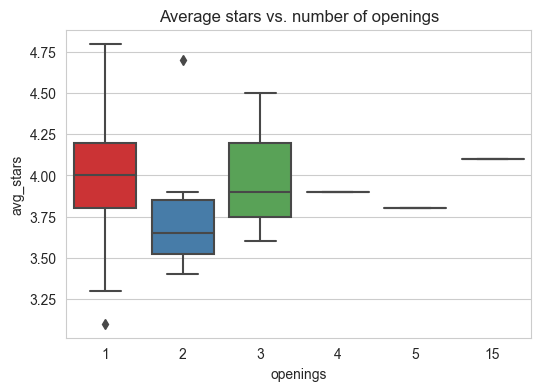

In [13]:
fig, ax = plt.subplots(figsize=(6,4))
g = sns.boxplot(data=company_stats, y='avg_stars', x = 'openings',  ax=ax, palette='Set1')
_ = ax.set_title("Average stars vs. number of openings")

In [14]:
# look at company totals - which company has the most jobs?
company_job_totals = data.company.value_counts().reset_index()
company_job_totals.rename(columns={"index": "company", "company":"job_count"}, inplace=True)
company_job_totals[:10]

,job_count,count
0,Bloomberg,15
1,"JPMorgan Chase Bank, N.A.",5
2,Citi,4
3,Etsy,3
4,Peloton,3
5,Kensho,3
6,Justworks,2
7,Metropolitan Transportation Authority,2
8,Amentum,2
9,Match Group,2


In [15]:
# let s look at all companies - not just those with 2 or more job openings - which have the highest avg stars?
company_avg_stars = data.groupby("company").agg({'stars':'mean','job_id':'count'})
company_avg_stars.sort_values(by='stars', ascending=False)[:10]


,stars,job_id
company,,
Notion,4.8,1
Philo,4.7,2
Prospect 33,4.6,1
Power Home Remodeling,4.6,1
Etsy,4.5,3
TECHSTRA SOLUTIONS,4.4,1
Mitchell Martin,4.3,1
Synchrony Financial,4.3,1
INFUSEmedia,4.3,1


In [16]:
temp = company_avg_stars.dropna().sort_values(by='stars', ascending=False).reset_index()
temp.head()

,company,stars,job_id
0,Notion,4.8,1
1,Philo,4.7,2
2,Prospect 33,4.6,1
3,Power Home Remodeling,4.6,1
4,Etsy,4.5,3


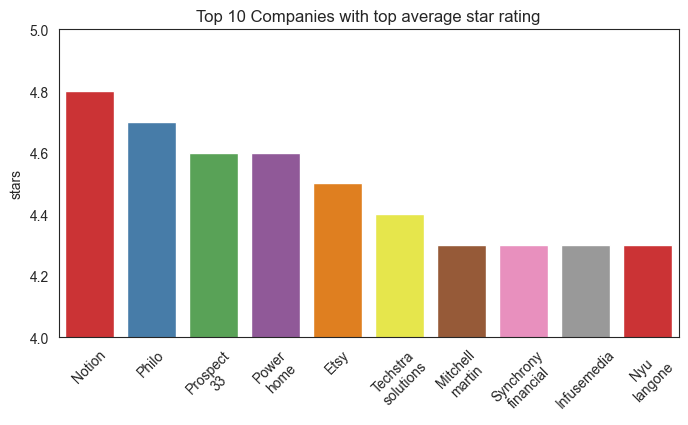

In [17]:
import matplotlib.ticker as ticker
sns.set_style('white')
fig, ax = plt.subplots(figsize=(8,4))
g = sns.barplot(data = temp[:10], x = 'company', y = 'stars', ax=ax, palette='Set1')
labels = [i.get_text() for i in g.get_xticklabels()]
labels = ["\n".join(i.capitalize().split(" ")[0:2]) for i in labels]
_ = ax.set_xticklabels(labels=labels, rotation = 45)
_ = ax.set_ylim((4,5))
_ = ax.set_title('Top 10 Companies with top average star rating')
_ = ax.set_xlabel("")
_ = ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(np.round(x,2), ',')))

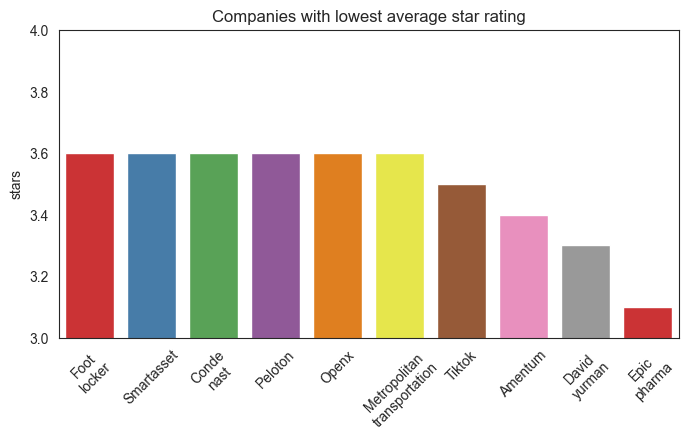

In [18]:
# lowest ranked companies (based on avg star rating)
fig, ax = plt.subplots(figsize=(8,4))
g = sns.barplot(data = temp[-10:], x = 'company', y = 'stars', ax=ax, palette='Set1')
labels = [i.get_text() for i in g.get_xticklabels()]
labels = ["\n".join(i.capitalize().split(" ")[0:2]) for i in labels]
_ = ax.set_xticklabels(labels=labels, rotation = 45)
_ = ax.set_title('Companies with lowest average star rating')
_ = ax.set_ylim((3,4))
_ = ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(np.round(x,2), ',')))
_ = ax.set_xlabel("")

In [19]:
# correlation between number of open positions and avg stars given
star_corr = company_avg_stars.dropna()
star_corr.columns = ['avg_star_rating', 'open_positions']
star_corr.corr()


,avg_star_rating,open_positions
avg_star_rating,1.000000,0.004194
open_positions,0.004194,1.000000


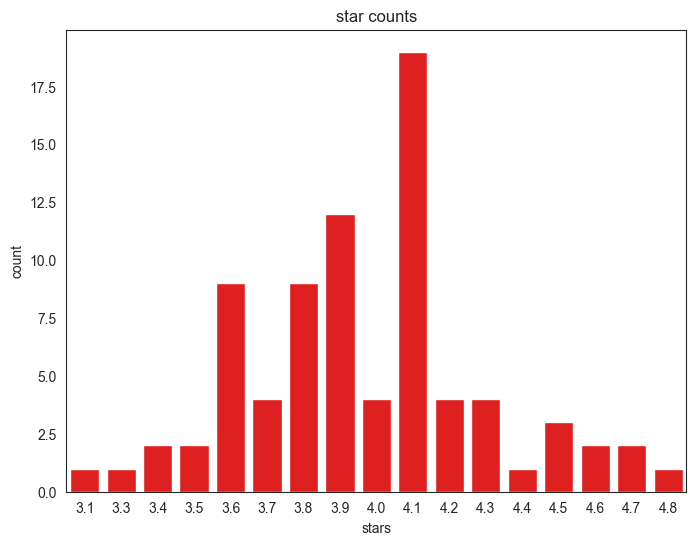

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
star_counts = data.stars.value_counts().reset_index()
g = sns.barplot(data=star_counts, y = 'count', x='stars', ax=ax, color='r')
_ = ax.set_title("star counts")

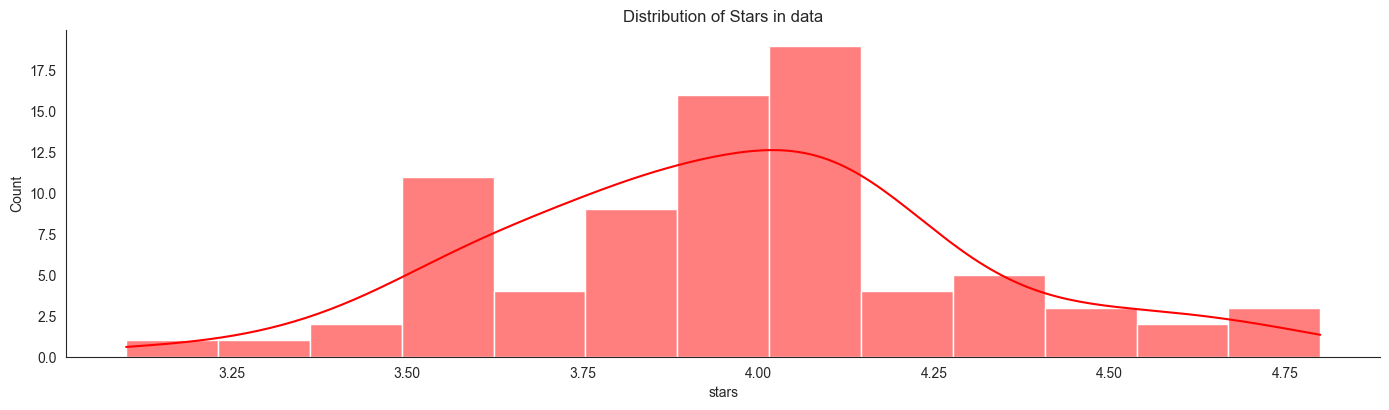

In [21]:
g = sns.displot(data, x = 'stars', color='red', kde=True, height=4, aspect=3.5)
_ = plt.title('Distribution of Stars in data')

In [22]:
# make a copy of data
df = data.copy()
# drop null reviews
df = df[~df.reviews.isnull()]

In [23]:
# drop duplicated review
df = df[~df.reviews.duplicated()]

### Text Preprocessing
* Remove punctuation, numbers and stopwords
* Remove numbers, whitespaces

In [24]:
# assign new clean review column
df = df.assign(clean_review = df.reviews.map(lambda x: ' '.join(TextBlob(str(x)).words)))
# Remove stopwords & lowercase
df.clean_review = df.clean_review.map(lambda x: " ".join([i.lower() for i in x.split() if i not in stopwords.words('english')]))
# remove numbers
df.clean_review = df.clean_review.map(lambda x: " ".join([i.strip(" ") for i in re.sub('[0-9]','',x).split()]))

In [25]:
df.clean_review.head()

0    good place retire since benefits good willing ...
1    great benefits company really tries fails trie...
2    interesting problems great people flexibility ...
5    good initiatives work life balance reviews gre...
0    work life balance good great among finance com...
Name: clean_review, dtype: object

### Word Cloud of top 5 reviews

In [28]:
# collect words
word_list = []
word_list.extend(df.clean_review.str.split())
# flatten list of words - exclude the word reviews
word_list = [item for row in word_list for item in row if item !='reviews']
# create counter - we want word frequencies
word_counts = Counter(word_list)

In [29]:
word_counts.most_common(10)

[('good', 123),
 ('work', 88),
 ('people', 77),
 ('great', 68),
 ('benefits', 67),
 ('culture', 58),
 ('balance', 54),
 ('pay', 50),
 ('management', 45),
 ('life', 43)]

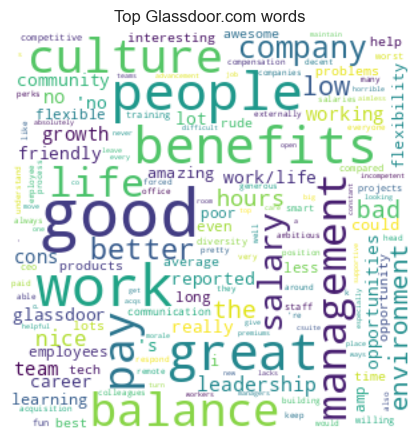

In [59]:
# Wordcloud
wordcloud = WordCloud(width = 300,
                      height = 300,
                      background_color='white',
                      max_font_size=50, max_words=150)

wordcloud = wordcloud.generate_from_frequencies(word_counts)

# plot words
plt.figure(figsize=(6,4),facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Top Glassdoor.com words")
plt.savefig("review_wordcloud.png")
plt.show()

### Polarity & Subjectivity using TextBlob
* polarity is between -1 and 1, and identifies the most negative as -1 and positive as 1
* subjectivity is between 0 and 1 and shows the amount of personal opinion
* TextBlob allows us to see the sentiment for each word using sentiment_assessment, so we can get a better understanding of how words are scored


### But can we trust stars given in reviews?

* We can see that polarity should be increasing as stars increase, but that is not the case.
* Polarity is higher for 3.75 star rated reviews than for reviews with 4.0 stars.
* We also see the review for the "worse" rating of 3.1 does not correspond to a negative review

In [31]:
sample_string = df.clean_review.iloc[0]
sample_string_stars = df.iloc[0].stars

In [38]:
# polarity
print(f"Sample Review:\n{sample_string}\nTextBlob polarity:{TextBlob(sample_string).sentiment.polarity}"
      f" and subjectivity:{TextBlob(sample_string).subjectivity}")

Sample Review:
good place retire since benefits good willing sacrifice salary/growth reviews great culture open learning environment reviews nice people work reviews very flexible good work life balance reviews good pay good hours reviews long hours culture staying late reviews difficult maintain good work/life balance reviews bad pay promotion hard get reviews
TextBlob polarity:0.26302083333333337 and subjectivity:0.6317708333333332


In [39]:
# assign column for polarity
df = df.assign(polarity = df.clean_review.map(lambda x: TextBlob(x).sentiment.polarity))
# assign column for subjectivity
df = df.assign(subjectivity = df.clean_review.map(lambda x: TextBlob(x).subjectivity))

In [40]:
# we can see the sentiment assessment of each word in our sample sentence
TextBlob(sample_string).sentiment_assessments[2]

[(['good'], 0.7, 0.6000000000000001, None),
 (['good'], 0.7, 0.6000000000000001, None),
 (['willing'], 0.25, 0.75, None),
 (['great'], 0.8, 0.75, None),
 (['open'], 0.0, 0.5, None),
 (['nice'], 0.6, 1.0, None),
 (['very'], 0.2, 0.3, None),
 (['good'], 0.7, 0.6000000000000001, None),
 (['good'], 0.7, 0.6000000000000001, None),
 (['good'], 0.7, 0.6000000000000001, None),
 (['long'], -0.05, 0.4, None),
 (['late'], -0.3, 0.6, None),
 (['difficult'], -0.5, 1.0, None),
 (['good'], 0.7, 0.6000000000000001, None),
 (['bad'], -0.6999999999999998, 0.6666666666666666, None),
 (['hard'], -0.2916666666666667, 0.5416666666666666, None)]

### Another example - review with minimum stars given
In this case, this review is not bad: Textblob identifies it as more positive than negative based on polarity closer to 1, but it has 3.5 stars


In [41]:
# let s find worse review
worse_stars = df.stars.min()
worse_review = df[df.stars == df.stars.min()].clean_review.values[0]
worse_company = df[df.stars == worse_stars].company.values[0]
w_polarity = TextBlob(worse_review).polarity
w_subjectivity = TextBlob(worse_review).subjectivity

In [42]:
# here we can see that this review is not bad: Textblob identifies it as more positive than negative based on polarity closer to 1
print(f"{worse_company} with {worse_stars} has the worse review:\n{worse_review}")
print(f"\nBut TextBlob indicates it has {w_polarity} polarity and {w_subjectivity}")

Epic Pharma LLC with 3.1 has the worse review:
the people working company nice reviews 'no cons reported glassdoor community

But TextBlob indicates it has 0.6 polarity and 1.0


In [44]:
# if we look at the sentiment assessments on its words:
TextBlob(worse_review).sentiment_assessments[2]

[(['nice'], 0.6, 1.0, None)]

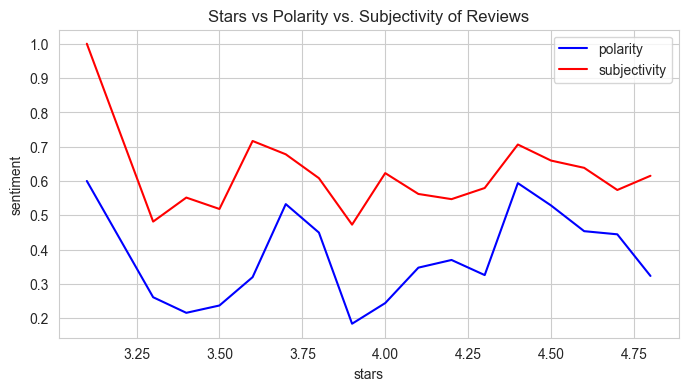

In [61]:
# we see how some higher star rated reviews have lower polarity
fig, ax = plt.subplots(figsize =(8,4))
sns.set_style("whitegrid")
g = sns.lineplot(data = df, x = 'stars', y='polarity', ax=ax, color = 'b', label='polarity', errorbar=None)
g1 = sns.lineplot(data = df, x = 'stars', y='subjectivity', ax=ax, color = 'r', label='subjectivity', errorbar=None)
_ = g.set_title("Stars vs Polarity vs. Subjectivity of Reviews")
_ = ax.set_ylabel("sentiment")
plt.savefig('textblob_sentiments.png')

# Polarity & Subjectivity using Vader

VADER is another Lexicon-based sentiment analyzer that has pre-defined rules for words or lexicons. VADER not only tells the lexicon is positive, negative, or neutral, it also tells how positive, negative, or neutral a sentence is.

The output from VADER comes in a Python dictionary in which we have four keys and their corresponding values. ‘neg’, ‘neu’, ‘pos’, and ‘compound’ which stands for Negative, Neutral, and Positive respectively. The Compound score is an indispensable score that is calculated by normalizing the other 3 scores (neg, neu, pos) between -1 and +1. The decision criteria are similar to TextBlob -1 is for most negative and +1 is for most positive.

In [49]:
# initialize sentiment analyzer
sid_obj = SentimentIntensityAnalyzer()

In [50]:
# going back to our sample string with 4.1 stars
sample_string

'good place retire since benefits good willing sacrifice salary/growth reviews great culture open learning environment reviews nice people work reviews very flexible good work life balance reviews good pay good hours reviews long hours culture staying late reviews difficult maintain good work/life balance reviews bad pay promotion hard get reviews'

In [51]:
# it has a high compound score! it's positive
sid_obj.polarity_scores(sample_string)

{'neg': 0.137, 'neu': 0.469, 'pos': 0.394, 'compound': 0.9646}

In [52]:
# assign sentiment scores
df = df.assign(sentiment_scores = df.clean_review.map(lambda x: sid_obj.polarity_scores(x)))
df = df.assign(compound_scores = df.sentiment_scores.map(lambda x: x.get('compound')))
df = df.assign(positive_scores = df.sentiment_scores.map(lambda x: x.get('pos')))
df = df.assign(negative_scores = df.sentiment_scores.map(lambda x: x.get('neg')))

In [53]:
# the avg compound >0.5 which is positive
df.compound_scores.describe()

count    63.000000
mean      0.847806
std       0.223204
min       0.000000
25%       0.824400
50%       0.954500
75%       0.975450
max       0.994500
Name: compound_scores, dtype: float64

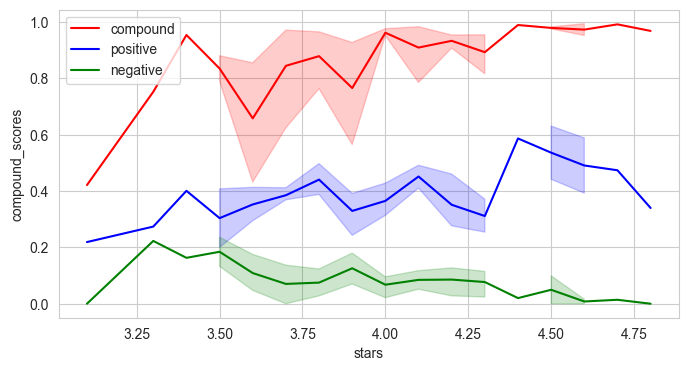

In [54]:
# sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8,4))
g = sns.lineplot(data = df, x = 'stars', y = 'compound_scores', ax=ax, color = 'r', label='compound')
g1 = sns.lineplot(data = df, x = 'stars', y = 'positive_scores', ax=ax, color = 'b', label ='positive')
g2 = sns.lineplot(data = df, x = 'stars', y = 'negative_scores', ax=ax, color = 'g', label ='negative')

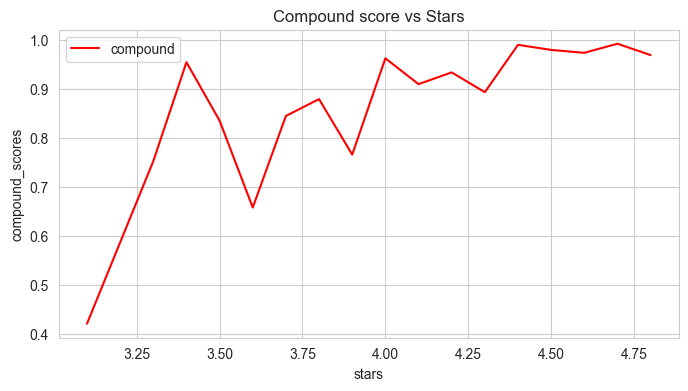

In [62]:
fig, ax = plt.subplots(figsize=(8,4))
g = sns.lineplot(data = df[~df.clean_review.duplicated()], x = 'stars', y = 'compound_scores', ax=ax, color = 'r',
                 label='compound', errorbar=None)
_ = plt.title("Compound score vs Stars")
_ = plt.savefig("vader_compoundscores.png")

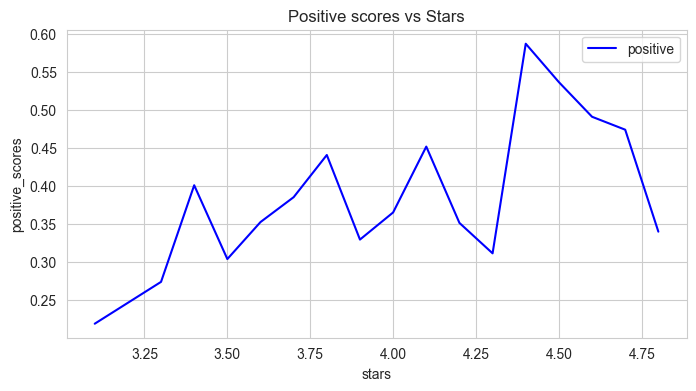

In [63]:
fig, ax = plt.subplots(figsize=(8,4))
g1 = sns.lineplot(data = df[~df.clean_review.duplicated()], x = 'stars', y = 'positive_scores',
                  ax=ax, color = 'b', label ='positive', errorbar=None)
_ = plt.title("Positive scores vs Stars")
_ = plt.savefig("vader_pos_scores.png")

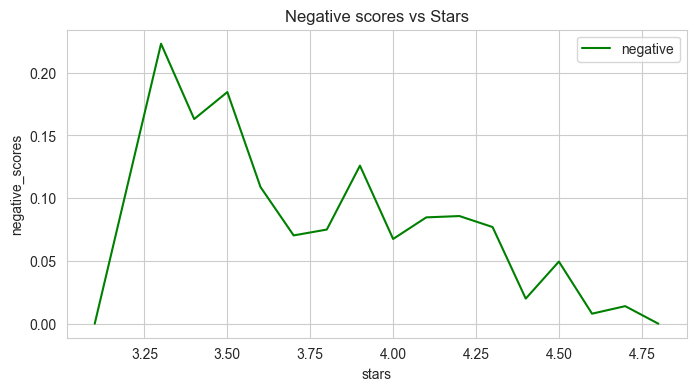

In [64]:
fig, ax = plt.subplots(figsize=(8,4))
g1 = sns.lineplot(data = df[~df.clean_review.duplicated()], x = 'stars', y = 'negative_scores',
                  ax=ax, color = 'g', label ='negative', errorbar=None)
_ = plt.title("Negative scores vs Stars")
_ = plt.savefig("vader_neg_scores.png")

In [58]:
# we see how compound scores align more with the review words than with stars given
df.sort_values(by='stars')[['clean_review','stars', 'compound_scores','positive_scores','negative_scores']][:10]

,clean_review,stars,compound_scores,positive_scores,negative_scores
0,the people working company nice reviews 'no co...,3.1,0.4215,0.219,0.000
14,nothing good really hope find better managemen...,3.3,0.7527,0.274,0.223
13,competitive pay reviews benefits decent well r...,3.4,0.9545,0.401,0.163
10,good benefits team bonding activities reviews ...,3.5,0.8807,0.408,0.236
15,work life balance good benefits reviews benefi...,3.5,0.7900,0.200,0.133
2,salary teamwork fantastic management room grow...,3.6,0.7351,0.383,0.000
12,lovely management great salary reviews culture...,3.6,0.8588,0.369,0.073
26,awesome people reviews good insurance reviews ...,3.6,0.9001,0.434,0.072
8,great people decent pay ready work reviews • f...,3.6,0.2960,0.255,0.252
7,culture people tremendous value diversity revi...,3.6,0.4005,0.230,0.000
